# Introduction

In this notebook we compare the PaSDqc variance estimate to the Median Absolute Pairwise Difference (MAPD) dispersion estimate. We also compare brute force ACF calculation to PaSDqc calculation

The PaSDqc ACF and variance estimates are calculate in the notebook Calculating_PaSDqc_Dispersion

The MAPD scores were calculated by calculating copy number in 1 kb, 5 kb, 10 kb, 50 kb, 100 kb, 500 kb, and 1 mb bins using the BICseq2 program and taking the median of the pairwise difference between all neighboring bins

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import sys
import scipy.stats
import pathlib

import PaSDqc

%matplotlib inline

In [3]:
sns.set_style('ticks', {'ytick.minor.size': 0.0, 'xtick.minor.size': 0.0})
sns.set_context('poster')

## Load the MAPD data for each subject

In [4]:
df_1465 = pd.read_table("1465_mapd_range.txt", header=None, names=['Sample', 1000, 5000, 10000, 50000, 100000, 500000, 1000000])
df_4638 = pd.read_table("4638_mapd_range.txt", header=None, names=['Sample', 1000, 5000, 10000, 50000, 100000, 500000, 1000000])
df_4643 = pd.read_table("4643_mapd_range.txt", header=None, names=['Sample', 1000, 5000, 10000, 50000, 100000, 500000, 1000000])

In [5]:
df_1465['Subject'] = '1465'
df_4638['Subject'] = '4638'
df_4643['Subject'] = '4643'

In [6]:
df_1465_melt = pd.melt(df_1465, id_vars=['Sample', 'Subject'])
df_4638_melt = pd.melt(df_4638, id_vars=['Sample', 'Subject'])
df_4643_melt = pd.melt(df_4643, id_vars=['Sample', 'Subject'])

In [7]:
df_mapd = pd.concat([df_1465_melt, df_4643_melt])

In [8]:
bins = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]

df_mapd_1465 = df_mapd[df_mapd.Subject == '1465']
mapd_1465_mean = np.array([df_mapd_1465.loc[df_mapd_1465.variable==b, 'value'].mean() for b in bins])
mapd_1465_se = np.array([2*df_mapd_1465.loc[df_mapd_1465.variable==b, 'value'].std() / np.sqrt(16) for b in bins])

df_mapd_4643 = df_mapd[df_mapd.Subject == '4643']
mapd_4643_mean = np.array([df_mapd_4643.loc[df_mapd_4643.variable==b, 'value'].mean() for b in bins])
mapd_4643_se = np.array([2*df_mapd_4643.loc[df_mapd_4643.variable==b, 'value'].std() / np.sqrt(16) for b in bins])

## Load the PSD data for each sbject

In [9]:
def load_psd(d):
    p = pathlib.Path(d)
    d_psd = p / 'psd'
    file_list = sorted(d_psd.glob("*.chroms.spec"))
    
    sample_list = [f.name.split('chroms.spec') for f in file_list]
    df_list = [pd.read_table(str(f), index_col=0) for f in file_list]
    psd_list = [PaSDqc.PSDTools.SamplePSD(df, name=s) for df, s in zip(df_list, sample_list)]
    avg_list = [psd.avg_PSD() for psd in psd_list]
    nd = np.array(avg_list)
    freq = np.array(df_list[0].index.tolist())
    
    return freq, nd

In [10]:
freq, psd_nd_1465 = load_psd("../data/Lodato_2015/1465/")
freq, psd_nd_4643 = load_psd("../data/Lodato_2015/4643/")

In [11]:
avg_1465 = np.mean(psd_nd_1465, axis=0)
sd_1465 = np.std(psd_nd_1465, axis=0)
avg_4643 = np.mean(psd_nd_4643, axis=0)
sd_4643 = np.std(psd_nd_4643, axis=0)

## Load MAPD and PaSDqc scores for convenience

In [7]:
df_mapd_normal = pd.read_csv("MAPD_vs_PaSDqc.txt")
df_mapd_comp = df_mapd_normal[df_mapd_normal.Subject.isin(['1465', '4643'])]

## Statistical performance of MAPD and PaSDqc in sample descrimination

In [8]:
scipy.stats.ks_2samp(df_mapd_comp[df_mapd_comp.Subject == 1465].MAPD, df_mapd_comp[df_mapd_comp.Subject == 4643].MAPD)

Ks_2sampResult(statistic=0.44999999999999996, pvalue=0.11759298980884779)

In [9]:
scipy.stats.ks_2samp(df_mapd_comp[df_mapd_comp.Subject == 1465].variance, df_mapd_comp[df_mapd_comp.Subject == 4643].variance)

Ks_2sampResult(statistic=1.0, pvalue=1.6756734066768405e-06)

## Load ACF data

Brute force ACF can be calculated using PaSDqc.extra_tools.ACF_brute()
* This is slow, memory intensive, and doesn't have great accuracy

In [10]:
a1 = np.arange(0, 1000, 100)
a2 = np.arange(1000, 10000, 1000)
a3 = np.arange(10000, 100000, 10000)
a4 = np.arange(100000, 1000000, 100000)
a5 = np.array([1000000])
lags = np.concatenate([a1, a2, a3, a4, a5])

In [11]:
p_cov = pathlib.Path("../data/Lodato_2015/1465/acf/")
f_list_acf = [f for f in sorted(p_cov.glob("*.acf")) if not 'Bulk' in f.name ]
df_brute_list = [pd.read_table(str(f), index_col=0) for f in f_list_acf]

df_acf = pd.read_table("1465_PaSDqc_ACF.txt")

In [12]:
df_acf_brute = pd.concat(df_brute_list, axis=1)
acf_brute_mean = df_acf_brute.mean(axis=1)
acf_brute_se = df_acf_brute.std(axis=1) / np.sqrt(16)

acf_qc_mean = df_acf['mean']
acf_qc_se = df_acf['se']

## Put all the plots together

In [13]:
def label_diff(x1, x2, y, text, ax, shrink=2):
    dx = abs(x2-x1)

    props = {'connectionstyle':'bar','arrowstyle':'-', 'lw': 2, 'shrinkA': shrink, 'shrinkB': shrink}# ,\
                 # 'shrinkA':20,'shrinkB':20,'lw':2}
    ax.annotate(text, xy=(x1,y+90), zorder=10)
    ax.annotate('', xy=(x1,y), xytext=(x2,y), arrowprops=props)

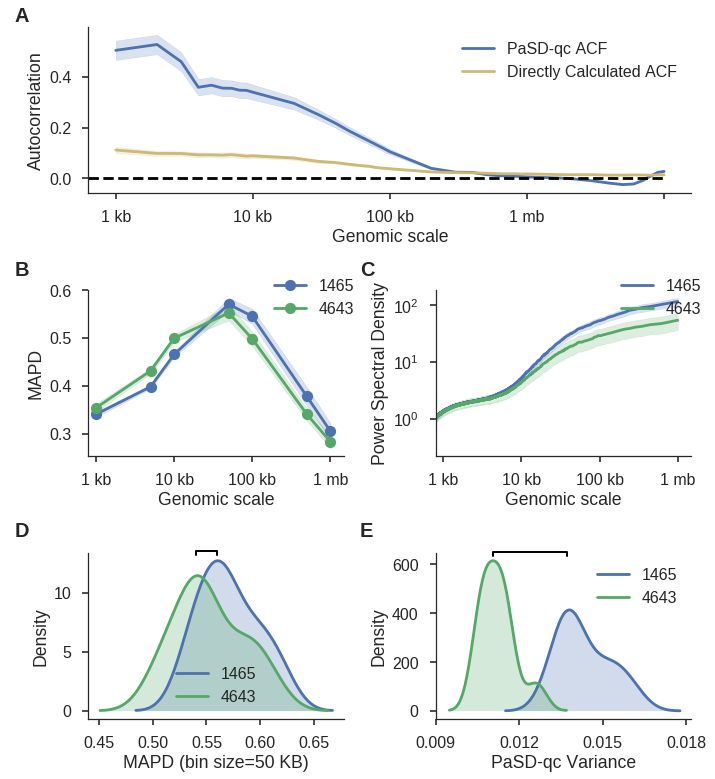

In [21]:
# f, ax = plt.subplots(nrows=2, ncols=2)
# plt.tight_layout(h_pad=3, w_pad=3)
f = plt.figure(figsize=(10, 11))
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax1 = plt.subplot2grid((3, 2), (1, 0))
ax2 = plt.subplot2grid((3, 2), (1, 1))
ax3 = plt.subplot2grid((3, 2), (2, 0))
ax4 = plt.subplot2grid((3, 2), (2, 1))

ax = np.array([[ax1, ax2], [ax3, ax4], [ax0, ax0]])

cp = sns.color_palette()
ax0.plot((1e3, 1e3), (0, 0))
ax0.plot(lags[1:], acf_qc_mean[1:] / acf_qc_mean[0], label='PaSD-qc ACF', color=cp[0])
ax0.fill_between(lags[1:], acf_qc_mean[1:] / acf_qc_mean[0] - 2*acf_qc_se[1:] / acf_qc_mean[0], acf_qc_mean[1:] / acf_qc_mean[0] + 2*acf_qc_se[1:] / acf_qc_mean[0], alpha=0.2, color=cp[0])

ax0.plot(lags[1:], acf_brute_mean[1:] / acf_brute_mean[0], label='Directly Calculated ACF', color=cp[4])
ax0.fill_between(lags[1:], acf_brute_mean[1:] / acf_brute_mean[0] - 2*acf_brute_se[1:] / acf_brute_mean[0], acf_brute_mean[1:] / acf_brute_mean[0] + 2*acf_brute_se[1:] / acf_brute_mean[0], alpha=0.2, color=cp[4])


ax0.set_xscale('log')
ax0.plot((0, 1e6), (0, 0), 'k--')
#sns.despine()
ax0.set_xlabel('Genomic scale')
ax0.set_ylabel('Autocorrelation')
ax0.set_xticklabels(["0", "100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])
ax0.legend()

# MAPD range plot
ax[0, 0].plot(bins, mapd_1465_mean, label='1465', marker='o')
ax[0, 0].fill_between(bins, mapd_1465_mean+mapd_1465_se, mapd_1465_mean-mapd_1465_se, color=cp[0], alpha=0.2)

ax[0, 0].plot(bins, mapd_4643_mean, label='4643', marker='o')
ax[0, 0].fill_between(bins, mapd_4643_mean+mapd_4643_se, mapd_4643_mean-mapd_4643_se, color=cp[1], alpha=0.2)

ax[0, 0].set_xlim(8e2, 1.5e6)
ax[0, 0].set_xscale('log')

ax[0, 0].set_xlabel('Genomic scale')
ax[0, 0].set_ylabel('MAPD')
ax[0, 0].legend(loc=(0.7, 0.8))
ax[0, 0].set_xticklabels(["0", "100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])

# PSD plot
ax[0, 1].plot(1/freq, avg_1465, label='1465')
ax[0, 1].fill_between(1/freq, avg_1465+sd_1465, avg_1465-sd_1465, alpha=0.2, color=cp[0])

ax[0, 1].plot(1/freq, avg_4643, label='4643')
ax[0, 1].fill_between(1/freq, avg_4643+sd_4643, avg_4643-sd_4643, alpha=0.2, color=cp[1])

ax[0, 1].set_xlim(8e2, 1.5e6)
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].legend(loc=(0.7, 0.8))

ax[0, 1].set_xlabel('Genomic scale')
ax[0, 1].set_ylabel('Power Spectral Density')
ax[0, 1].set_xticklabels(["0", "100 bp", "1 kb", "10 kb", "100 kb", "1 mb"])

# MAPD at 50000
sns.kdeplot(df_mapd_comp[df_mapd_comp.Subject == 1465].MAPD, shade=True, label='1465', ax=ax[1, 0])
sns.kdeplot(df_mapd_comp[df_mapd_comp.Subject == 4643].MAPD, shade=True, label='4643', ax=ax[1, 0])
ax[1, 0].set_xlabel('MAPD (bin size=50 KB)')
ax[1, 0].set_ylabel('Density')
label_diff(0.54, 0.56, 13, '', ax[1, 0])

# Variance
sns.kdeplot(df_mapd_comp[df_mapd_comp.Subject == 1465].variance, shade=True, label='1465', ax=ax[1, 1])
sns.kdeplot(df_mapd_comp[df_mapd_comp.Subject == 4643].variance, shade=True, label='4643', ax=ax[1, 1])
ax[1, 1].set_xlabel('PaSD-qc Variance')
ax[1, 1].set_ylabel('Density')
ax[1, 1].set_xticks([9e-3, 1.2e-2, 1.5e-2, 1.8e-2])
label_diff(0.01105, 0.0137, 560, '     ***', ax[1, 1], shrink=18)

# Despine
sns.despine(fig=f)

f.text(0.01, 0.98, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.01, 0.66, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.49, 0.66, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.01, 0.33, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
f.text(0.49, 0.33, "E", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=20)
plt.tight_layout(h_pad=2)